<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Projet de conception en génie physique GPH-3110 </b><br>
<b> Département de physique, de génie physique et d'optique </b><br>
<b> Hiver 2023 </b><br>
<b> Université Laval </b><br>

<center><h1>Thermistor voltage - temperature simulation</h2></center>

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = "svg"

import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
plt.rcParams.update(
    {
        "lines.linewidth": 1.5,
        "axes.labelsize": "x-large",
        "axes.labelpad": 10,
        "axes.grid": True,
        "axes.grid.which": "both",
        "grid.linestyle": ":",
        "grid.color": "k",
        "grid.alpha": 0.5,
        "xtick.minor.visible": True,
        "xtick.direction": "in",
        "xtick.major.size": 10,
        "xtick.major.width": 1,
        "xtick.minor.size": 5,
        "xtick.minor.width": 0.5,
        "ytick.minor.visible": True,
        "ytick.direction": "in",
        "ytick.major.size": 10,
        "ytick.major.width": 1,
        "ytick.minor.size": 5,
        "ytick.minor.width": 0.5,
    }
)

## Steinhart-Hart equation

The Steinhart-Hart equation is a model of the resistance $R$ of a semiconductor at different temperatures $T$. The equation is
\begin{gather}
    \frac{1}{T}=A+B\ln{\left(\frac{R}{R_{25}}\right)}+C\ln\left(\frac{R}{R_{25}}\right)^2+D\ln{\left(\frac{R}{R_{25}}\right)}^3 \ ,
\end{gather}

### Find $A$, $B$, $C$ and $D$ with curve fit

#### Extract thermistor data from datasheet

In [4]:
data = read_excel("NTCLE350E4103FHB0.xlsx", header=1)
data = data.to_numpy()

# Thermistor nominal resistance (25°C)
R25 = 10e3

T = data[:, 0]
R = data[:, 1]
ln = data[:, 2]
dR = data[:, 3]
alpha = data[:, 4]
dT = data[:, 5]
Rmin = data[:, 6]
Rmax = data[:, 7]

# Steinhart-Hart coefficients according to documentation
A = 0.00335401643468053
B = 0.000256523550896126
C = 2.60597012072052e-06
D = 6.32926126487455e-08

#### Define Steinhart-Hart equations

In [30]:
def steinhart_hart(R: np.ndarray | float) -> np.ndarray | float:
    """Calculate thermistor temperature with Steinhart-Hart equation.

    Parameters:
    -----------
        R : float
            Thermistor resistance.

    Returns:
    --------
        T : float
            Thermistor temperature in kelvin.

    """
    global A, B, C, D, R25

    ln = R/R25
    temp = A + B*np.log(ln) + C*np.log(ln)**2 + D*np.log(ln)**3
    temp = temp**-1 - 273.15
    return temp


def steinhart_curvefit(R, A, B, C, D):
    global R25

    temp = A + B*np.log(R) + C*np.log(R)**2 + D*np.log(R)**3
    temp = temp**-1 - 273.15
    return temp


def inv_steinhart(T: np.ndarray| float) -> np.ndarray | float:
    """Calculate thermistor resistance with Steinhart-Hart equation.

    Args:
        T : np.ndarray or float
            Thermistor temperature in celsius.

    Returns:
        R : np.ndarray or float.
            Thermistor resistance in ohms.

    """
    a = np.where(data[:, 0]==T)
    if len(a) > 0:
        return data[:, 1][a][0]

    global A, B, C, D, R25
    
    # Convert temperature to absolute
    temp = T + 273.15

    R = R25*np.exp(A + B/temp + C/temp**2 + D/temp**3)
    return R

In [6]:
# Exemple
steinhart_hart(11e3)
inv_steinhart(25)

10033.605107461202

#### Curve fit data

In [18]:
coeffs = np.array((A, B, C, D))
p0 = [1e-4, 1e-4, 1e-6, 1e-7]  # Guess with provided values
popt, _ = curve_fit(steinhart_curvefit, R, T, p0=coeffs)

# Keep average of the two sets
av = 0.5*(popt + coeffs)
precision = np.abs(0.5*(popt-av))

print(f"Provided coeffs: {coeffs}")
print(f"Fitted coeffs: {popt}")
print(f"Average coeffs: {av}")
print(f"Coeffs precision: {precision}")

Provided coeffs: [3.35401643e-03 2.56523551e-04 2.60597012e-06 6.32926126e-08]
Fitted coeffs: [1.16305649e-03 2.24640258e-04 8.49792847e-07 6.37588556e-08]
Average coeffs: [2.25853646e-03 2.40581905e-04 1.72788148e-06 6.35257341e-08]
Coeffs precision: [5.47739985e-04 7.97082311e-06 4.39044319e-07 1.16560741e-10]


#### Plot fitted data

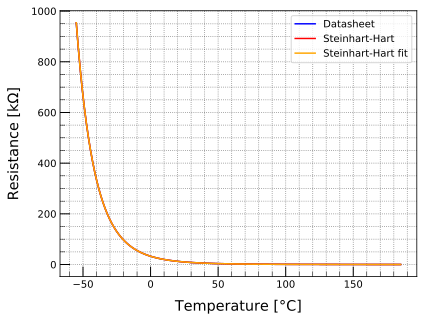

In [40]:
plt.plot(T, R*1e-3, "b", label="Datasheet")
plt.plot(steinhart_hart(R), R*1e-3, "r", label="Steinhart-Hart")
plt.plot(steinhart_curvefit(R, *popt), R*1e-3, "orange", label="Steinhart-Hart fit")
# plt.plot(res, np.abs(np.subtract(temp, steinhart_hart(res, *popt))), "g", label="error values")
plt.ylabel("Resistance [k$\Omega$]")
plt.xlabel("Temperature [$\degree$C]")
plt.legend()
plt.show()

## Weatstone bridge
<center><img src="https://upload.wikimedia.org/wikipedia/commons/9/93/Wheatstonebridge.svg" width=300></center>

The thermistor resistance $R_x$ is given by
\begin{gather}
    R_x = R + \Delta R \ , \tag{2}
\end{gather}

where $R$ is the nominal thermistor resistance at 25&deg;C and $\Delta R$ is the resistance change of the thermistor. From Kirchhoff's laws and the fact that $R_1=R_2=R_3=R$, we have
\begin{align}
    V_G &= \frac{V_{out}}{G} = B - D = V_s\left[\frac{R+\Delta R}{2R+\Delta R}-\frac{1}{2}\right] \ , \tag{3} \\[0.25cm]
    &= \frac{\Delta R}{4R+2\Delta R}V_s \ , \tag{4} \\[0.25cm]
    \Delta R &= -\frac{4RV_{out}}{2V_{out}-GV_s} \ , \tag{5} \\[0.25cm]
    R_x &= R+\Delta R = R\left(1 - \frac{4V_{out}}{2V_{out}-GV_s}\right) \ , \tag{6}
\end{align}

where $V_s$ is the supply voltage, $V_{out}$ is the amplifier output voltage and $G$ is the amplifier gain.

In [21]:
def simulation(dV: float, G: float | int = 1, R: int = 10e3, Vs: float = 3.3) -> float:
    """Calculate thermistor temperature based on amplifier's output voltage.

    Parameters:
    -----------
        dV : float
            _description_
        G : float or int, optional
            Amplifier gain. Defaults to 1.
        R : int, optional
            Thermistor nominal resistance at 25°C. Defaults to 10 000.
        Vs : float, optional
            Weatstone bridge supply voltage in volts. Defaults to 3.3.

    Returns:
    --------
        T : float
            Thermistor temperature in °C.

    """
    Rx = R*(1 - (4*dV) / (2*dV - G*Vs))
    T = steinhart_hart(Rx)
    return T

#### Simulation results

In [22]:
# Try with experimental values
s = simulation(0.26892, G=1.494)
print(f"Temperature: {s:.3f}°C")

Temperature: 20.076°C


## Current calculation

In [33]:
def current(T: float, Vs: float = 3.3, n: int = 1) -> float:
    """Calculate thermistors current consumption.

    Args:
        T : float
            Thermistor temperature in celsius
        Vs : float, optional
            Thermistors supply voltage. Defaults to 3.3V.
        n : int, optional
            Number of supplied thermistors per reading sequence. Defaults to 1.

    Returns:
        I : float
            Total current consumption in amps.

    """
    R = inv_steinhart(T)
    error = 1/R + 1
    I = Vs*n / (R + error)
    return I

In [34]:
# Test
current(150, n=16)

0.28951255001485615